# PRODUCT RECOMMENDER SYSTEM

## Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Loading Dataset

In [11]:
df=pd.read_csv(r"C:\datasets\merrec.csv")

In [13]:
df.head()

,user_id,item_id,session_id,action_type,timestamp,category,price,title
0,user_722,item_4258,session_471,click,2023-04-06T01:40:17,home,312.56,Item 0
1,user_399,item_4200,session_704,favorite,2023-04-22T06:43:36,electronics,49.71,Item 1
2,user_290,item_4654,session_2189,click,2023-04-29T02:51:06,fashion,406.19,Item 2
3,user_8,item_655,session_2621,favorite,2023-04-04T11:54:45,electronics,421.67,Item 3
4,user_621,item_2425,session_1124,click,2023-04-12T04:32:40,fashion,78.23,Item 4


In [15]:
## Data Preprocessing

In [17]:
df.isnull().sum()

user_id        0
item_id        0
session_id     0
action_type    0
timestamp      0
category       0
price          0
title          0
dtype: int64

In [78]:
df.columns

Index(['user_id', 'item_id', 'session_id', 'action_type', 'timestamp',
       'category', 'price', 'title', 'label'],
      dtype='object')

In [85]:
df.shape

(10000, 9)

In [19]:
df['label'] = (df['action_type'] == 'favorite').astype(int)

In [89]:
# outlier removal

In [87]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
print(f"Data shape after outlier removal: {df.shape}")

Data shape after outlier removal: (10000, 9)


In [21]:
# Encode categorical columns

In [23]:
label_encoders = {}
for col in ['user_id', 'item_id', 'session_id', 'category', 'title']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [91]:
#data visualisation

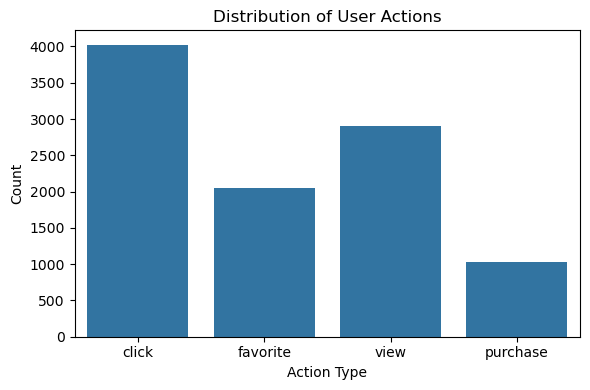

In [93]:
plt.figure(figsize=(6,4))
sns.countplot(x='action_type', data=df)
plt.title("Distribution of User Actions")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

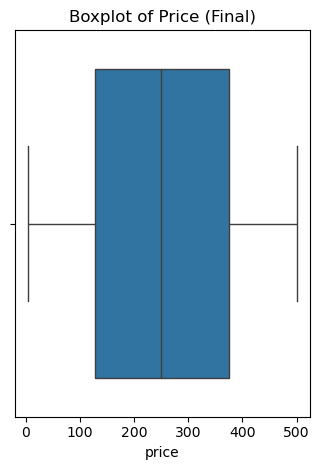

In [97]:
plt.subplot(1, 2, 2)
sns.boxplot(x='price', data=df)
plt.title("Boxplot of Price (Final)")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Price Distribution (Final)')

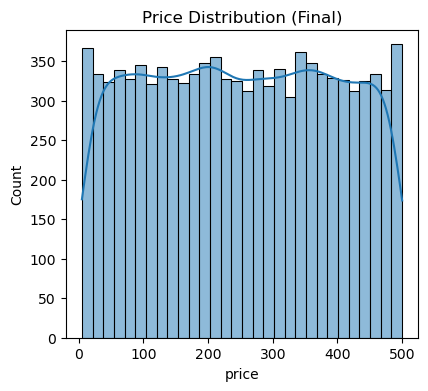

In [95]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=30)
plt.title("Price Distribution (Final)")


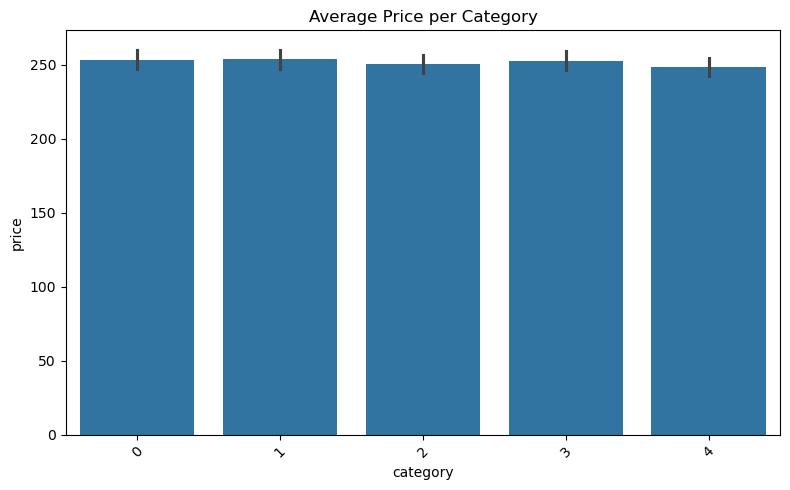

In [103]:
plt.figure(figsize=(8,5))
sns.barplot(x='category', y='price', data=df, estimator=np.mean)
plt.title("Average Price per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


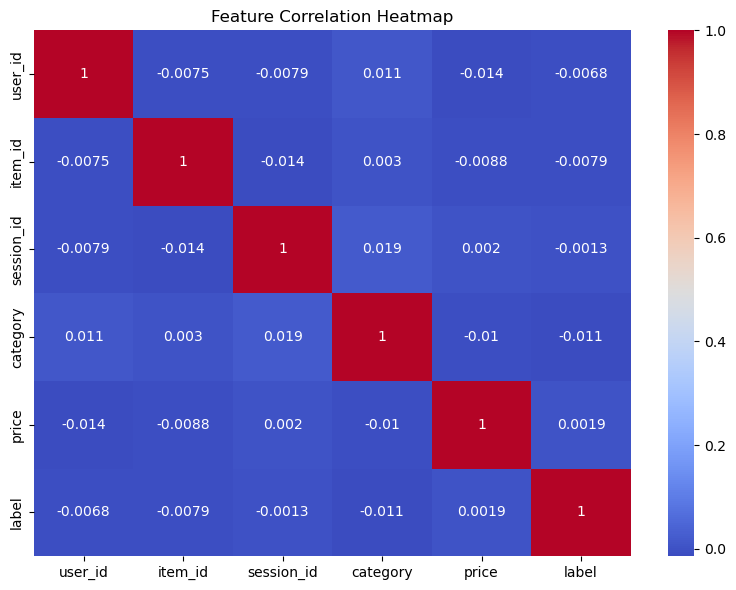

In [101]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['user_id', 'item_id', 'session_id', 'category', 'price', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [25]:
# Selecting features and target x,y

In [27]:
features = ['user_id', 'item_id', 'session_id', 'category', 'price']
X = df[features]
y = df['label']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
## Define and Train Supervised Models

In [33]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

In [35]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }


In [36]:
metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

In [37]:
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression    0.7945   0.000000  0.000000  0.000000  0.504746
1        Decision Tree    0.6680   0.210526  0.223844  0.216981  0.503363
2        Random Forest    0.7895   0.083333  0.002433  0.004728  0.507459
3    Gradient Boosting    0.7920   0.142857  0.002433  0.004785  0.539241
4                  SVM    0.7945   0.000000  0.000000  0.000000  0.536578
5                  KNN    0.7540   0.170732  0.051095  0.078652  0.480190


In [41]:
#Visualize Evaluation Metrics

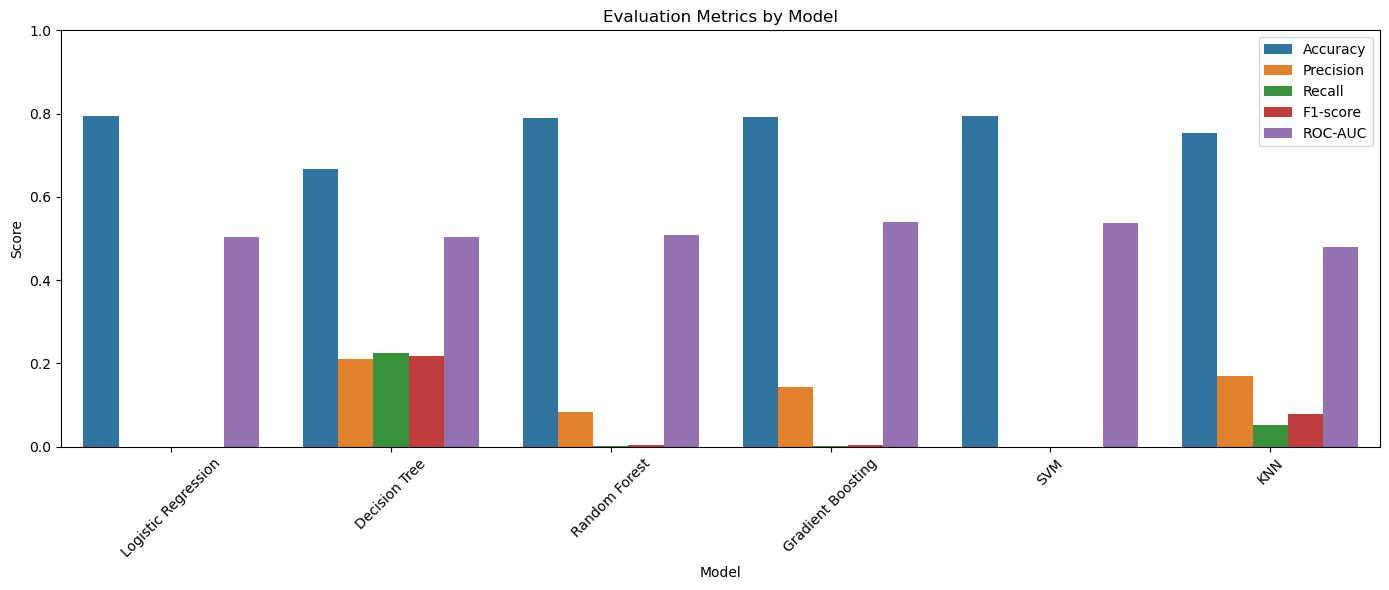

In [43]:
plt.figure(figsize=(14, 6))
melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.title("Evaluation Metrics by Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [45]:
#Plot Confusion Matrices for All Models

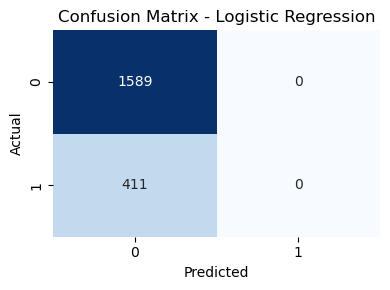

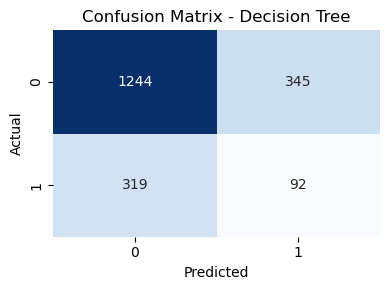

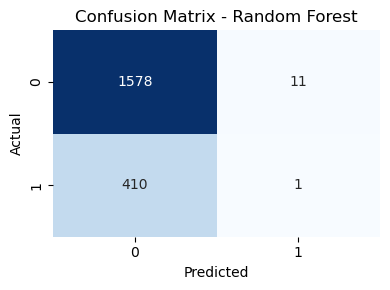

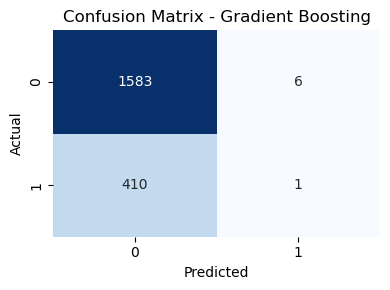

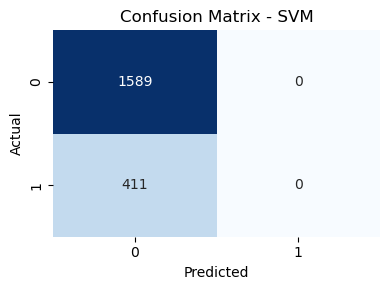

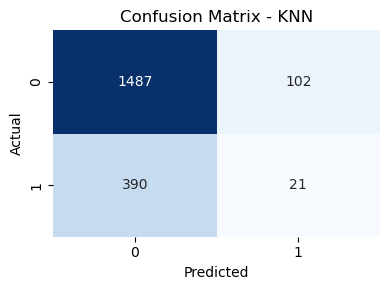

In [47]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [49]:
 #Generate Top-N Recommendations

In [56]:
best_model = models['Gradient Boosting']

## Prepare for recommendations

In [54]:
unique_users = df['user_id'].unique()
unique_items = df['item_id'].unique()
interactions = set(zip(df['user_id'], df['item_id']))

In [58]:
# Sample a few users

In [60]:
sample_users = np.random.choice(unique_users, size=3, replace=False)
top_n = 5
recommendations = {}

In [62]:
# Generate top-N items per user

In [64]:
for user in sample_users:
    candidates = []
    for item in unique_items:
        if (user, item) not in interactions:
            session_id = df['session_id'].mode()[0]
            category = df['category'].mode()[0]
            price = df[df['item_id'] == item]['price'].mean()
            if np.isnan(price):
                continue
            candidates.append([user, item, session_id, category, price])

    candidate_df = pd.DataFrame(candidates, columns=features)
    if not candidate_df.empty:
        probs = best_model.predict_proba(candidate_df)[:, 1]
        candidate_df['score'] = probs
        top_recs = candidate_df.sort_values(by='score', ascending=False).head(top_n)
        recommendations[user] = top_recs[['item_id', 'score']].reset_index(drop=True)


In [65]:
print(recommendations)

{135:    item_id     score
0        1  0.467298
1     4287  0.436610
2      639  0.399198
3        7  0.380269
4        8  0.380110, 32:    item_id     score
0      639  0.546055
1        1  0.522183
2     4287  0.484480
3     3973  0.446292
4     3758  0.438284, 906:    item_id     score
0        1  0.495744
1     4287  0.493574
2     3111  0.472112
3     1299  0.423470
4        7  0.407471}


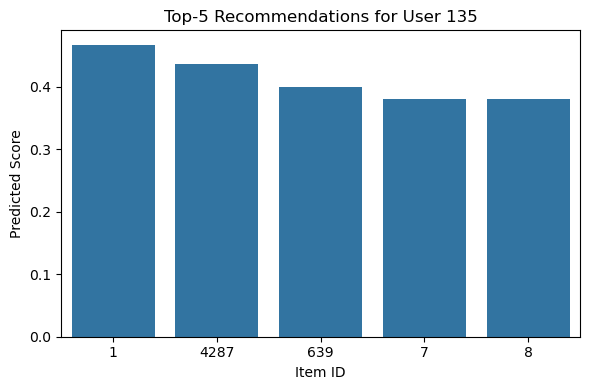

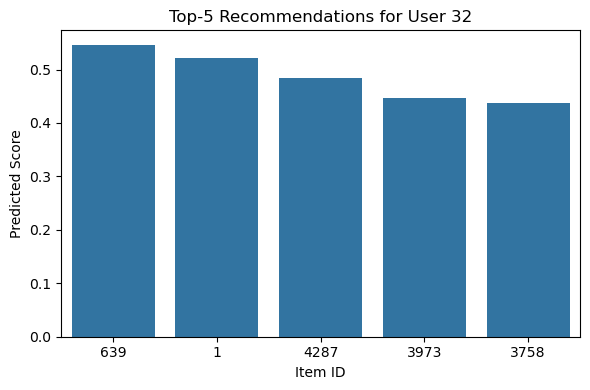

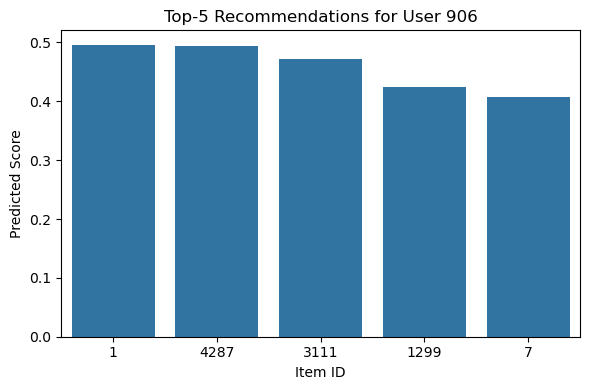

In [68]:
for user, recs in recommendations.items():
    plt.figure(figsize=(6, 4))
    sns.barplot(x=recs['item_id'].astype(str), y=recs['score'])
    plt.title(f"Top-{top_n} Recommendations for User {user}")
    plt.xlabel("Item ID")
    plt.ylabel("Predicted Score")
    plt.tight_layout()
    plt.show()